In [80]:
""" Nice geo-scatter plot """

import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import os,sys
import os
import xarray as xr
import numpy as np

import h5py as h5
import os,sys

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from multiprocessing import Pool
from functools  import partial

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


out_dir = 'Plots/Stations_Locations'
os.system('mkdir  Plots' )
os.system('mkdir  ' + out_dir )

<ipython-input-80-e4d8fa0d8e7c>:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


256

In [85]:
db_path = '/mnt/users/scratch/leo/scratch/converted_v7'
files = [db_path + '/' + f for f in os.listdir(db_path)  if '.nc' in f and 'CEUAS' in f ]

#files = files[:100]
#file = files[0]

In [86]:
def get_timestamps(file):
    """ Read the input file, read the header table, extracts the number of records """
    
    f = h5.File(file, 'r')
    station = file.split('/')[-1].split('_CEUAS_')[0]
    #print(station)
    
    timestamps = f['header_table']['record_timestamp'][:] / (365.25*60*60*24) + 1900
    #print(max(timestamps), min(timestamps))
    
    lat, lon = f['header_table']['latitude'][0] , f['header_table']['longitude'][0] 
    #print(lat,lon)
    
    
    mins  = [1900, 1940, 1960, 1980, 2000, 2010]
    maxes = [1940, 1960, 1980, 2000, 2010, 2020]    
    
    res = {'lat':lat, 'lon':lon, 'station':station }
    
    for m,M in zip (mins, maxes):
        counts = len (np.where( (timestamps>= m) & (timestamps < M) )[0] )
        res[str(m)+'-'+str(M)] = counts
    
    return res


    
    

In [87]:
if not os.path.isfile('records_time_range.npy'):
    p = Pool(30)
    func = partial(get_timestamps)
    out = p.map(func, files)
    
    all_res = {}

    keys = out[0].keys()

    for k in keys:
        all_res[k] = []
        for o in out:
            all_res[k].append(o[k])
    
    np.save( 'records_time_range.npy', all_res, allow_pickle = True)
else:
    all_res = np.load('records_time_range.npy', allow_pickle = True).item()  

In [88]:
#all_res

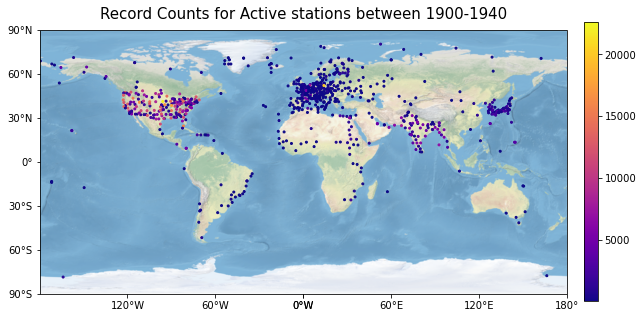

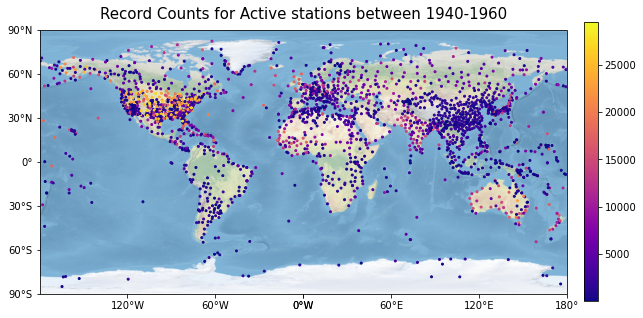

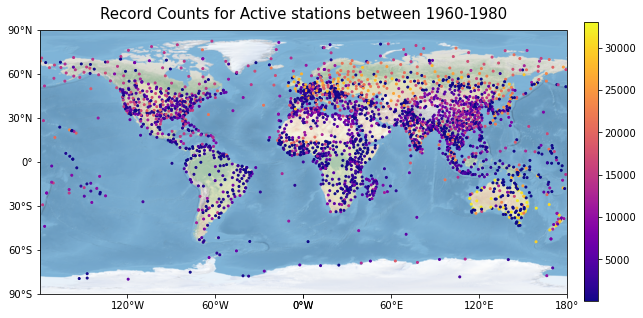

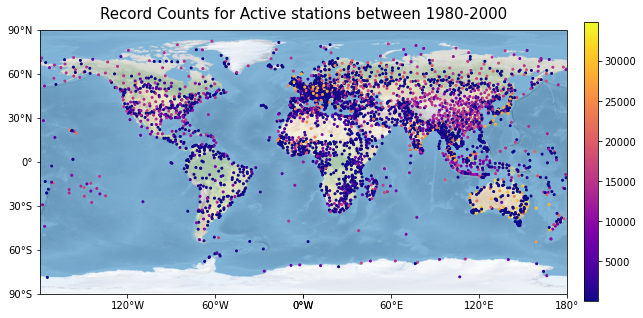

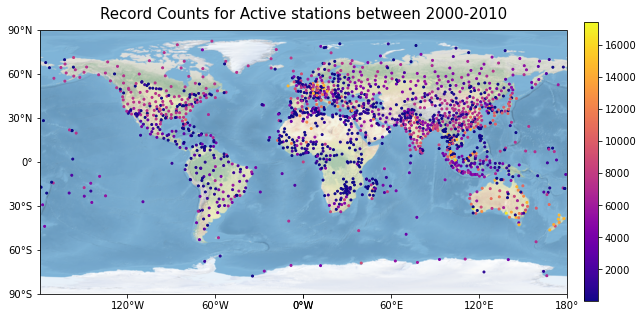

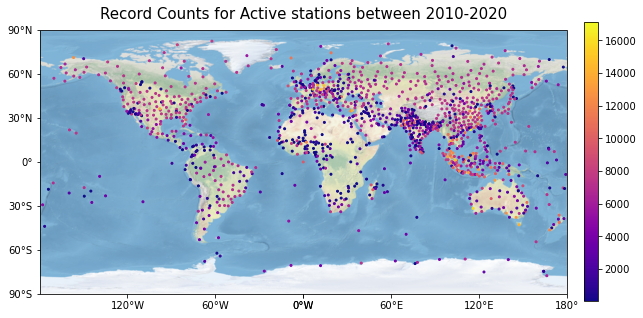

In [94]:
def make_plot_cartopy(all_res, date):
    
    fs = 15
    fig = plt.figure(figsize=(10,20))

    #ax1 = plt.axes(projection=ccrs.PlateCarree())
    
    ax1 = plt.subplot(211, projection=ccrs.PlateCarree(central_longitude=0))

    ax1.stock_img()
    ax1.set_global()
    #ax1.coastlines()
    
    ax1.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    ax1.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    
    
    indices = list(np.where(np.array(all_res[date]) >0)[0])
    #print(indices)
    #print(all_res[date])
    #print(np.array(all_res[date])[indices])
    plt.scatter(np.array(all_res['lon'])[indices], np.array(all_res['lat'])[indices] ,
         c=np.array(all_res[date])[indices], marker='o', s=4,
         transform=ccrs.PlateCarree(),
         cmap = 'plasma'
         )
    
    cbar = plt.colorbar(fraction=0.025, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
    #cbar.set_label('Record Counts', fontsize = fs)
    #plt.clim(4000, 5000)

    plt.title('Record Counts for Active stations between ' + date , fontsize = fs, y =1.02 )

    plt.savefig('Plots/Stations_Locations/record_counts_' + d + '.png', dpi = 200)
    plt.show()

for d in ['1900-1940' , '1940-1960', '1960-1980', '1980-2000', '2000-2010', '2010-2020']:
    dummy = make_plot_cartopy(all_res, d)